## Imports

In [3]:
# basic imports
import random
import numpy as np
import os

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

In [4]:
# try to import the library, if already present 
# good to go, else install it and then import library
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

## 1. Dataset

In [5]:
dataset_path = '../dataset/'
output_path = '../output/'

In [6]:
DATA_DIR = "../../data/Potsdam/patches/500px"

x_train_dir = os.path.join(DATA_DIR, 'rgb')
y_train_dir = os.path.join(DATA_DIR, 'label')

x_valid_dir = os.path.join(DATA_DIR, 'rgb_valid')
y_valid_dir = os.path.join(DATA_DIR, 'label_valid')

x_test_dir = os.path.join(DATA_DIR, 'rgb_test')
y_test_dir = os.path.join(DATA_DIR, 'label_test')

In [7]:
impervious = [255, 255, 255]
building = [0, 0, 255]
vegetation = [0, 255, 255]
tree = [0, 255, 0]
car = [255, 255, 0]
clutter = [255, 0, 0]

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == impervious,axis=-1)] = 0
    label_seg [np.all(label==building,axis=-1)] = 1
    label_seg [np.all(label==vegetation,axis=-1)] = 2
    label_seg [np.all(label==tree,axis=-1)] = 3
    label_seg [np.all(label==car,axis=-1)] = 4
    label_seg [np.all(label==clutter,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [8]:
from torchvision import transforms

preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

In [9]:
# from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['impervious', 'building', 'vegetation', 'tree', 'car', 'clutter']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            patch_size=512
    ):
        self.im_ids = os.listdir(images_dir) 
        # self.im_ids = list(filter(lambda x: x.endswith('11_RGB.tif'), self.im_ids))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.im_ids]
        self.mask_ids = os.listdir(masks_dir) 
        # self.mask_ids = list(filter(lambda x: x.endswith('11_label.tif'), self.mask_ids))
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.mask_ids]
        
        self.dims = (patch_size, patch_size)
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.dims, interpolation=cv2.INTER_NEAREST)
        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) # cv2 reads image as BGR, change to RGB
        mask = cv2.resize(mask, self.dims, interpolation=cv2.INTER_NEAREST)
        mask = rgb_to_2D_label(mask)
        # print(self.images_fps[i])
        
        # # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        # mask = np.stack(masks, axis=-1).astype('float')
        # if len(self.class_values) < len(self.CLASSES):
        #     mask = np.c_[np.zeros((np.shape(mask)[0], np.shape(mask)[1], 1)), mask] # add column to make everything not in selected classes background
        mask = torch.from_numpy(mask).long()
        
        # # apply augmentations
        # if self.augmentation:
        #     sample = self.augmentation(image=image, mask=mask)
        #     image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image)
            
        return image, mask
        
    def __len__(self):
        return len(self.im_ids)

#### Dataloaders

- Dataloaders help load data in batches
- We'll need to define separate dataloaders for training, validation and test sets



In [10]:
from torch.utils.data import DataLoader

# train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)
CLASSES=['impervious', 'building', 'vegetation', 'tree', 'car', 'clutter']

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    # augmentation=get_training_augmentation(), 
    preprocessing=preprocess,
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    # augmentation=get_validation_augmentation(), 
    preprocessing=preprocess,
    classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    # augmentation=get_validation_augmentation(), 
    preprocessing=preprocess,
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)#, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)#, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)#, num_workers=4)

### Show Sample images from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


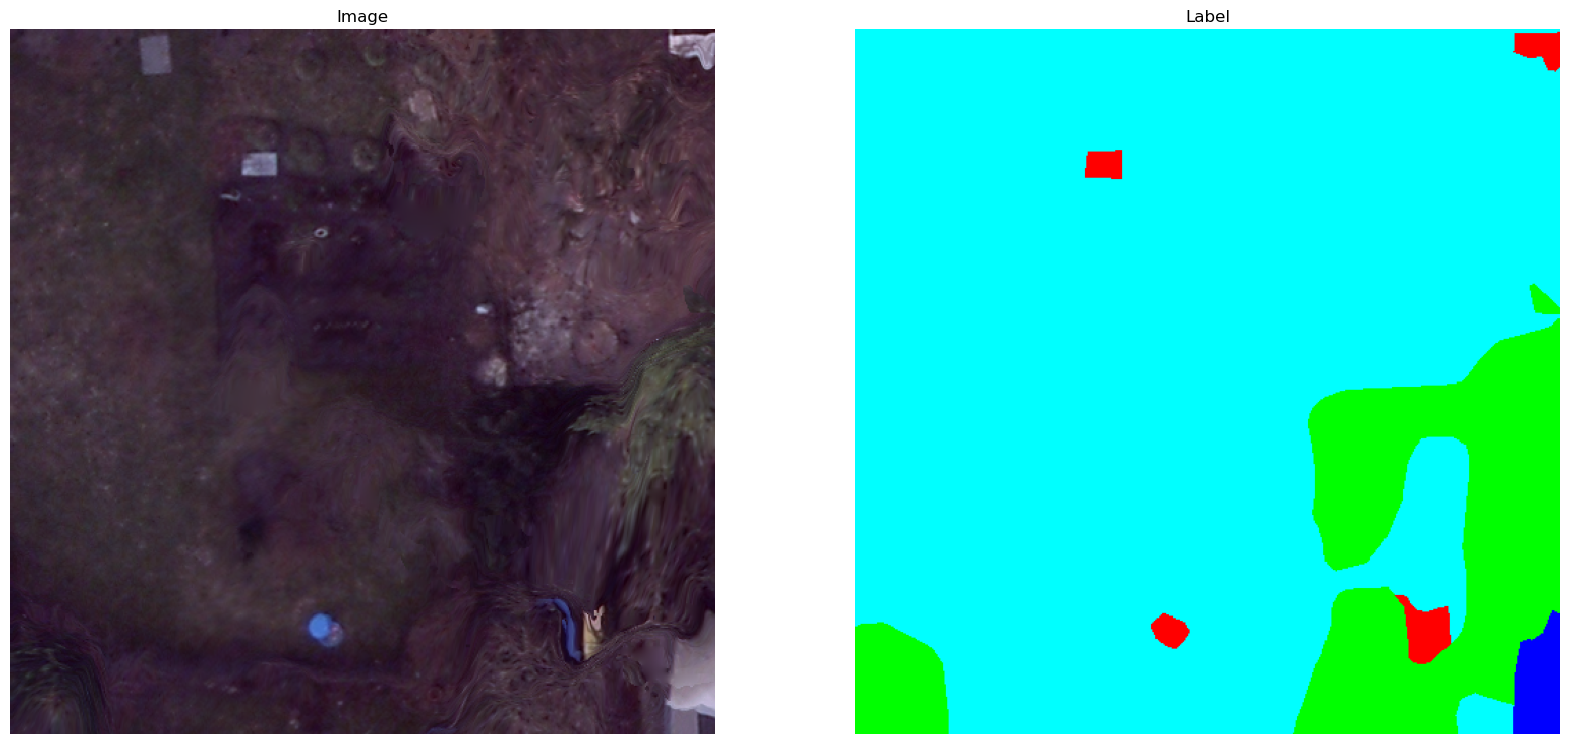

In [11]:
from utils import inverse_transform, train_id_to_color

rgb_image, label = train_dataset[np.random.choice(len(train_dataset))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

## 2. Network: Define a UNet Encoder-Decoder
Pay close attention to the image, this is what we are going to code:
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Notice the 3 main elements:
* The Encoder
* The Decoder
* The Skip-Connections

In [12]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

In [15]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, layer_channels):
        super(UNetEncoder, self).__init__()
        self.encoder = nn.ModuleList()

        # Double Convolution blocks
        for num_channels in layer_channels:
            self.encoder.append(double_conv(in_channels, num_channels))
            in_channels = num_channels
        
        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        # Pass input image through Encoder blocks
        # and return outputs at each stage
        skip_connections = []
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        return x, skip_connections			
			
			
class UNetDecoder(nn.Module):
    def __init__(self, layer_channels):
        super(UNetDecoder, self).__init__()
        self.decoder = nn.ModuleList()

        # Decoder layer Double Convolution blocks
        # and upsampling blocks
        self.decoder = nn.ModuleList()        
        for num_channels in reversed(layer_channels):
            self.decoder.append(nn.ConvTranspose2d(num_channels*2, num_channels, kernel_size=2, stride=2))
            self.decoder.append(double_conv(num_channels*2, num_channels))
        
    
    def forward(self, x, skip_connections):
        for idx in range(0, len(self.decoder), 2):
            # upsample output and reduce channels by 2
            x = self.decoder[idx](x)
            
            # if skip connection shape doesn't match, resize
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            
            # concatenate and pass through double_conv block
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)
        return x		



class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, layer_channels):
        super(UNet, self).__init__()
        
        # Encoder and decoder modules
        self.encoder = UNetEncoder(in_channels, layer_channels)
        self.decoder = UNetDecoder(layer_channels)

        # conv layer to transition from encoder to decoder and 
        # 1x1 convolution to reduce num channels to out_channels
        self.bottleneck = double_conv(layer_channels[-1], layer_channels[-1]*2)
        self.final_conv = nn.Conv2d(layer_channels[0], out_channels, kernel_size=1)
        
        # initialize parameters now to avoid modifying the initialization of top_blocks
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                # nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder blocks
        encoder_output, skip_connections = self.encoder(x)

        # transition between encoder and decoder
        x = self.bottleneck(encoder_output)

        # we need the last skip connection first
        # so reversing the list 
        skip_connections = skip_connections[::-1]

        # Decoder blocks
        x = self.decoder(x, skip_connections)

        # final 1x1 conv to match input size
        return self.final_conv(x)          	

Nice work! Let's now train this model!

## 3. Training : Train and validate model on the custom dataset

In [16]:
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

### Hyperparameters

In [19]:
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# device = 'cpu'
print(device)

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
# criterion = smp.losses.DiceLoss('multiclass', log_loss = True, smooth=1.0)
criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 20
NUM_CLASSES = 6
MAX_LR = 3e-4
# MODEL_NAME = 'UNet_baseline_jaccardloss'

# create model, optimizer, lr_scheduler and pass to training function
model = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS, steps_per_epoch = len(train_loader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

cuda:0


In [20]:
from utils import IoU
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

MODEL_NAME = 'UNet_baseline_jaccardloss_noScheduler'

# _ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
#                          device, train_loader, valid_loader, IoU, 'metrices',
#                          NUM_CLASSES, lr_scheduler = None, output_path = output_path)

# Tests

In [21]:
# MODEL_NAME = 'UNet_baseline_test
MODEL_PATH = os.path.join(output_path,MODEL_NAME, MODEL_NAME+'_last.pt')
print(MODEL_PATH)
# model_jacc = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device) 

checkpoint = torch.load(MODEL_PATH)
# model_jacc.load_state_dict(checkpoint_jacc['model_state_dict'])

print(checkpoint['results'])

../output/UNet_baseline_jaccardloss_noScheduler/UNet_baseline_jaccardloss_noScheduler_last.pt
[{'epoch': 0, 'trainLoss': 0.6875752947988019, 'validationLoss': 0.46485907484149924, 'metrices': {'accuracy': 0.7370470099978976, 'classwise_accuracy': array([0.82922774, 0.72049965, 0.83570588, 0.59148755, 0.65480001,
       0.13563145]), 'miou': 0.5100709113799263, 'classwise_iou': array([0.644523  , 0.66050817, 0.59164414, 0.47880685, 0.60152722,
       0.08341608])}, 'duration_train': datetime.timedelta(seconds=383, microseconds=602980)}, {'epoch': 1, 'trainLoss': 0.569661047605295, 'validationLoss': 0.42489130144208, 'metrices': {'accuracy': 0.7622094896104601, 'classwise_accuracy': array([0.82585281, 0.79560166, 0.87592784, 0.55608263, 0.81428066,
       0.16462087]), 'miou': 0.5479616837690883, 'classwise_iou': array([0.67621182, 0.70933986, 0.61349064, 0.48617407, 0.69542289,
       0.10713082])}, 'duration_train': datetime.timedelta(seconds=378, microseconds=72908)}, {'epoch': 2, 'tr

../output/UNet_baseline_test/UNet_baseline_test_last.pt
model already exists. load last states..
Best epoch: 42
Starting 43 epoch ...


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


Epoch: 43, trainLoss:0.31468, validationLoss:0.58174, validation_metrices: {'accuracy': 0.5458578109741211, 'classwise_accuracy': array([0.41515629, 0.53231759, 0.6621279 , 0.57884185, 0.39292572,
       0.13553478]), 'miou': 0.2923276059872097, 'classwise_iou': array([0.28349964, 0.43996456, 0.50078254, 0.30444822, 0.18221211,
       0.04305857])}, ttainingDuration: 0:00:03.612186
Starting 44 epoch ...


100%|██████████| 20/20 [00:03<00:00,  6.54it/s]


Epoch: 44, trainLoss:0.30516, validationLoss:0.59144, validation_metrices: {'accuracy': 0.5019363403320313, 'classwise_accuracy': array([0.40293133, 0.49927464, 0.60511733, 0.46981585, 0.6156078 ,
       0.28447117]), 'miou': 0.25803102312689125, 'classwise_iou': array([0.27423612, 0.42596897, 0.4115734 , 0.26777503, 0.09695324,
       0.07167938])}, ttainingDuration: 0:00:02.241014
Starting 45 epoch ...


100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Epoch: 45, trainLoss:0.30426, validationLoss:0.59402, validation_metrices: {'accuracy': 0.4825471878051758, 'classwise_accuracy': array([0.48806063, 0.42036832, 0.51087793, 0.56327225, 0.49161582,
       0.21723738]), 'miou': 0.2669142915100601, 'classwise_iou': array([0.28083031, 0.37562599, 0.38102067, 0.27461331, 0.2205674 ,
       0.06882807])}, ttainingDuration: 0:00:01.968686
Early stopped training at epoch 44


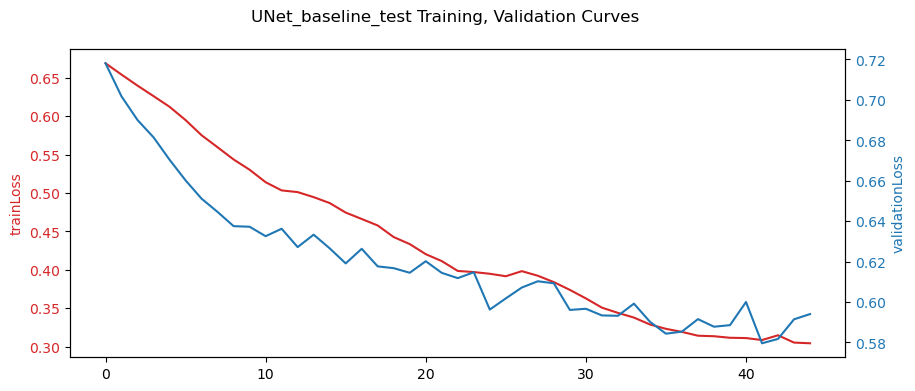

In [21]:
from utils import IoU
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

MODEL_NAME = 'UNet_baseline_'

# reference : https://smp.readthedocs.io/en/latest/losses.html
# criterion = smp.losses.DiceLoss('multiclass', log_loss = True, smooth=1.0)
criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 70
NUM_CLASSES = 6
MAX_LR = 3e-4
# MODEL_NAME = 'UNet_baseline_jaccardloss'

# create model, optimizer, lr_scheduler and pass to training function
model = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS, steps_per_epoch = len(train_loader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

subset_loader1 = DataLoader(torch.utils.data.Subset(train_dataset, range(20)), batch_size=1, shuffle=False)
subset_loader2 = DataLoader(torch.utils.data.Subset(valid_dataset, range(20)), batch_size=1, shuffle=False)


# _ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
#                          device, train, subset_loader2, IoU, 'metrices',
#                          NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

## Continue Training

In [21]:
MODEL_NAME = 'UNet_baseline_jaccardloss_noScheduler'
MODEL_PATH = os.path.join(output_path, MODEL_NAME+'_general.pt')

N_EPOCHS = 2

metrices = IoU

criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)

# model = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device) 
# optimizer = optim.Adam(model.parameters(), lr=MAX_LR)

checkpoint = torch.load(MODEL_PATH)
# model.load_state_dict(checkpoint['model_state_dict'])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# checkpoint = torch.load(MODEL_PATH)
model_ = checkpoint['model']
optimizer_ = checkpoint['optimizer']
scheduler_ = checkpoint['lr_scheduler']
# scheduler = OneCycleLR(optimizer_, max_lr= MAX_LR, epochs = N_EPOCHS, steps_per_epoch = len(train_loader), 
#                        pct_start=0.3, div_factor=10, anneal_strategy='cos')
# steps = N_EPOCHS * len(train_loader)
# scheduler_.state_dict()['_schedule_phases'][1]['end_step'] += steps
# scheduler_.state_dict()['total_steps'] += steps
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


# _ = train_validate_model(model_, N_EPOCHS, MODEL_NAME, criterion, optimizer_, 
#                          device, train_loader, valid_loader, IoU, 'metrices',
#                          NUM_CLASSES, lr_scheduler = None, output_path = output_path, results = checkpoint['results'])

Starting 7 epoch ...


  1%|          | 8/1008 [00:02<05:54,  2.82it/s]


KeyboardInterrupt: 

In [ ]:
!pip install torchstat

In [ ]:
MODEL_NAME = 'UNet_baseline_test
MODEL_PATH = os.path.join(output_path,MODEL_NAME, MODEL_NAME+'_epoch_4.pt')
print(MODEL_PATH)
# model_jacc = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device) 

checkpoint_jacc = torch.load(MODEL_PATH)
# model_jacc.load_state_dict(checkpoint_jacc['model_state_dict'])

print(checkpoint_jacc['results'])

In [21]:
test_loader = DataLoader(torch.utils.data.Subset(test_dataset, range(1)), batch_size=1, shuffle=False)
# torch.set_printoptions(threshold=2000)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_loader, criterion, metrices, NUM_CLASSES, device)
# print(f"\nModel has {test_metric[0]} IoU per class and {test_metric[1]} mean IoU in test set")
print(test_metric)

100%|██████████| 1/1 [00:05<00:00,  5.04s/it]

{'hist': array([[1.30000e+01, 1.00000e+02, 6.38000e+02, 7.26000e+02, 0.00000e+00,
        0.00000e+00],
       [1.25300e+03, 1.89392e+05, 7.43000e+02, 4.00000e+00, 2.00000e+00,
        1.26900e+03],
       [8.26700e+03, 4.31900e+03, 3.01120e+04, 1.74560e+04, 0.00000e+00,
        1.42600e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 1.68300e+03, 0.00000e+00,
        0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [4.85000e+02, 8.20000e+01, 7.50000e+02, 6.51000e+02, 6.00000e+01,
        2.71300e+03]]), 'accuracy': 0.8541603088378906, 'classwise_accuracy': array([0.00880162, 0.98302217, 0.48898993, 1.        ,        nan,
       0.57224214]), 'miou': 0.31353528678039333, 'classwise_iou': array([0.00113221, 0.96058104, 0.47263424, 0.08201754, 0.        ,
       0.36484669])}



/home/j/j_sten07/thesis_test/Semantic-Segmentation-using-Deep-Learning/finalContent/utils.py:254: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(hist) / hist.sum(axis = 1)


# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [23]:
MODEL_PATH = os.path.join(output_path,MODEL_NAME, MODEL_NAME+'_best.pt')
checkpoint = torch.load(MODEL_PATH)
model = checkpoint['model']
# model.to(device)
# model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
_, test_metric = evaluate_model(model, test_loader, criterion, IoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} metrices in test set")

100%|██████████| 720/720 [05:53<00:00,  2.04it/s]


Model has {'accuracy': 0.8295776685078938, 'classwise_accuracy': array([0.87989761, 0.94131838, 0.84491766, 0.75591747, 0.84802608,
       0.2946083 ]), 'miou': 0.6604745669066363, 'classwise_iou': array([0.74017368, 0.84072241, 0.68991748, 0.68550452, 0.78843009,
       0.21809922])} IoU in test set


In [24]:
from utils import visualize_predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


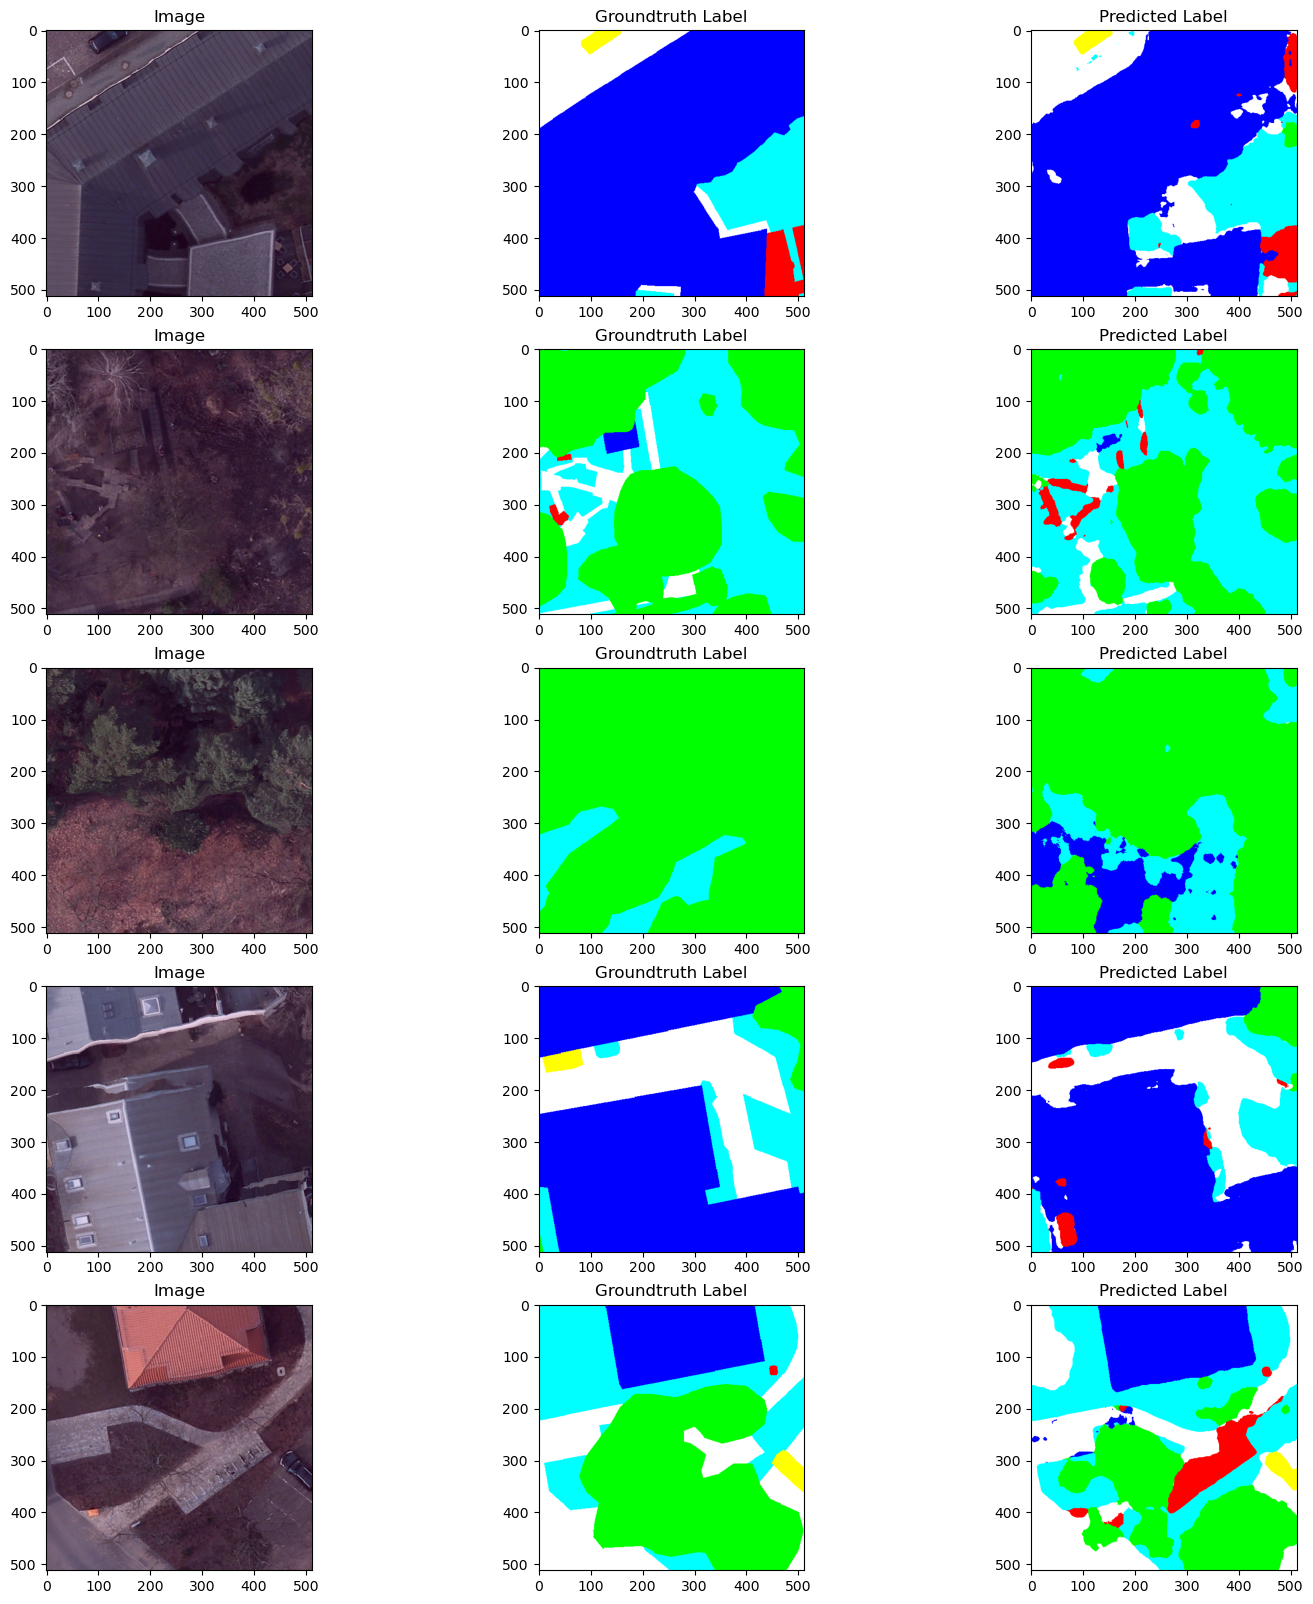

In [27]:
num_test_samples = 5
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_dataset, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)